In [7]:
import numpy as np
import pyvista as pv
import matplotlib.pyplot as plt
from scipy.spatial import cKDTree

### 1. Load Mesh and Define Parameters

In [3]:
# Enable notebook rendering with static backend
pv.set_jupyter_backend('static')

# Load the intraoral mesh
intraoral_mesh = pv.read(r'D:\sunny\Codes\DPS\data\Origin\000101_origin.ply')

# Calculate the y-range of the mesh
y_min = np.min(intraoral_mesh.points[:, 1])
y_max = np.max(intraoral_mesh.points[:, 1])

### 2. Initialize 2D Grid on Cylinders

In [4]:
# Define the resolution of the 2D grid
grid_resolution_theta = 256
grid_resolution_y = 1028

# Discretize theta values and y-values
theta_values_grid = np.linspace(-np.pi/2, 3*np.pi/2, grid_resolution_theta)
y_values_grid = np.linspace(y_min, y_max, grid_resolution_y)
theta_grid, y_grid = np.meshgrid(theta_values_grid, y_values_grid)

### 3. Utility Functions for UV Mapping

In [11]:
# Function to map 2D grid point (theta, y) to 3D point on the cylindrical screen
def map_to_3d_point_cylinder(radius, theta, y, inward_facing=True):
    x = radius * np.cos(theta)
    z = radius * np.sin(theta)
    return np.array([x, y, z])

# Function to generate ray direction from a cylindrical screen pixel
def generate_ray_direction(radius, theta, inward_facing=True):
    direction = np.array([np.cos(theta), 0, np.sin(theta)])
    if inward_facing:
        return -direction
    else:
        return direction

# Function to calculate face normals
def calculate_normals(mesh):
    mesh.compute_normals(cell_normals=True, point_normals=False, inplace=True)
    return mesh.cell_normals

# Function to check if a face is forward-facing
def is_forward_facing(normal, ray_direction):
    return np.dot(normal, ray_direction) < 0

### 4. Rasterize and Project the Mesh

In [12]:
# Calculate face normals
normals = calculate_normals(intraoral_mesh)

# Build a KD-tree for efficient nearest neighbor search
kdtree = cKDTree(intraoral_mesh.points)

# Function to rasterize and project the mesh onto the cylindrical screen
def rasterize_and_project_cylinder(mesh, radius, theta_values, y_values, inward_facing, normals):
    projected_colors = np.zeros((grid_resolution_y, grid_resolution_theta, 3))
    for i in range(grid_resolution_theta):
        for j in range(grid_resolution_y):
            theta = theta_values[i]
            y = y_values[j]
            origin = map_to_3d_point_cylinder(radius, theta, y, inward_facing)
            ray_direction = generate_ray_direction(radius, theta, inward_facing)
            distances, vertex_indices = kdtree.query(origin + ray_direction * 0.01, k=3)
            for dist, idx in zip(distances, vertex_indices):
                face_normal = normals[idx]
                if is_forward_facing(face_normal, ray_direction):
                    projected_colors[j, i] = mesh.point_data['RGB'][idx] / 255.0
                    break
    return projected_colors

# Calculate radii for the outer and inner cylinders
distance_to_origin = np.linalg.norm(intraoral_mesh.points[:, [0, 2]], axis=1)
outer_radius = np.max(distance_to_origin)
inner_radius = np.min(distance_to_origin)

# Rasterize and project the mesh onto the outer and inner cylindrical screens
projected_colors_outer = rasterize_and_project_cylinder(intraoral_mesh, outer_radius, theta_values_grid, y_values_grid, inward_facing=True, normals=normals)
projected_colors_inner = rasterize_and_project_cylinder(intraoral_mesh, inner_radius, theta_values_grid, y_values_grid, inward_facing=False, normals=normals)


### 5. Visualize the Projected Textures

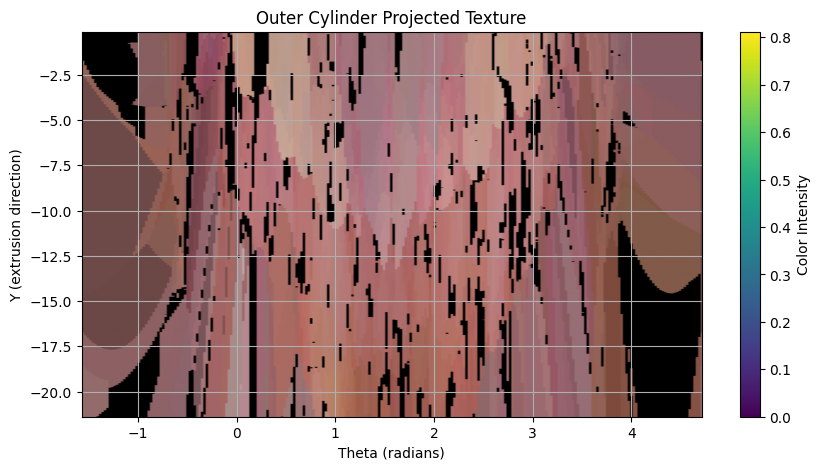

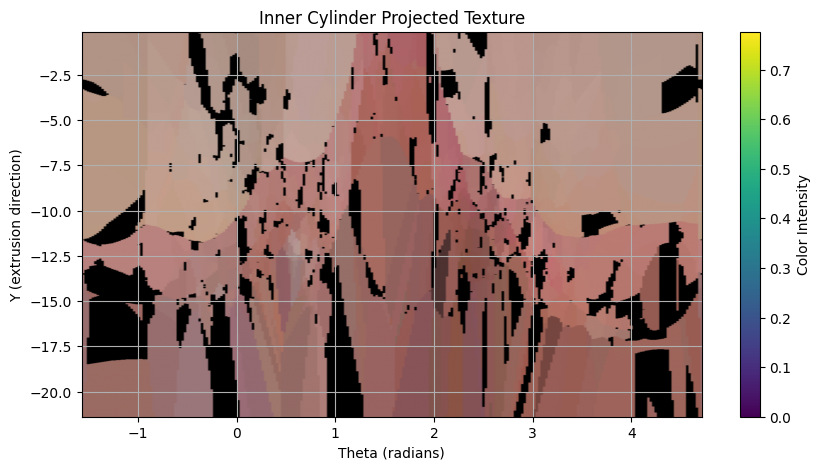

In [13]:
# Visualize the projected textures
def visualize_projected_texture(projected_colors, title):
    plt.figure(figsize=(10, 5))
    plt.imshow(projected_colors, extent=[-np.pi / 2, 3 * np.pi / 2, y_min, y_max], origin='lower', aspect='auto')
    plt.title(title)
    plt.xlabel('Theta (radians)')
    plt.ylabel('Y (extrusion direction)')
    plt.colorbar(label='Color Intensity')
    plt.grid(True)
    plt.show()

visualize_projected_texture(projected_colors_outer, 'Outer Cylinder Projected Texture')
visualize_projected_texture(projected_colors_inner, 'Inner Cylinder Projected Texture')
